# Outcome Modeling

- **Name:** Claude Fried
- **Pace:** Part-time
- **Scheduled project review date/time:** 
- **Instructor name:** James Irving
- **Blog post URL:** 

Taking advantage of Google Colab's TPUs and processing capacities, we were able to train our two sklearn models and experiment with Neural Network architectures.

We were able to get the best generalizations with a deep but small Neural Network, however the size and speed of the models will play a role in deployment.

### Imports

In [1]:
# # Run this cell if running from Colab.
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import re
import time
import pickle
import joblib
import bz2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

from scipy import sparse
from scipy.stats import ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score, 
                             log_loss)
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.models import load_model

In [3]:
import baseball_support as bsb
from league_player_classes import *

In [4]:
# # Run this cell if running from Colab.
# import drive.MyDrive.capstone.baseball_support as bsb
# from drive.MyDrive.capstone.league_player_classes import *

In [5]:
modeling_path = './modeling/'
os.listdir(modeling_path)

['.ipynb_checkpoints', 'data', 'preprocessor']

In [6]:
# # Run this cell if running from Colab.
# modeling_path = './drive/MyDrive/capstone/modeling/'
# os.listdir(modeling_path)

In [7]:
# Set random seed.
np.random.seed(2021)
tf.random.set_seed(2021)
tf.compat.v1.set_random_seed(2021)

# Check for device.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Prevents using GPU.
print(bsb.headerize(tf.test.gpu_device_name()))

********************************************************************************
*                                                                              *
********************************************************************************


In [8]:
(X_preprocessor, 
 y_preprocessor, 
 WEIGHTS_DCT,
 X_train, 
 y_train, 
 X_test, 
 y_test) = bsb.load_modeling_tools(modeling_path)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Loading...
Loaded: X_test_processed
Loaded: X_train_processed
Loaded: y_test_processed
Loaded: y_train_processed
Loaded: WEIGHTS_DCT
Loaded: X_preprocessor
Loaded: y_preprocessor
Complete!


((8084697, 16452), (8084697,), (2694900, 16452), (2694900,))

# Modeling

## Sklearn

In [9]:
TRAIN_SKLEARN = False
SGD_PATH = './models/sgd.pkl'
DT_PATH = './models/dt.pkl'

In [10]:
# # Run this cell if running from Colab.
# SGD_PATH = './drive/MyDrive/capstone/sgd.pkl'
# DT_PATH = './drive/MyDrive/capstone/dt.pkl'

### SGD (Logistic Regression)

In [11]:
if TRAIN_SKLEARN:
    log_sgd = SGDClassifier(loss='log',
                            random_state=2021)
    log_sgd.fit(X_train, y_train)
    joblib.dump(log_sgd, SGD_PATH)
else:
    log_sgd = joblib.load(SGD_PATH)

### Decision Tree

In [12]:
if TRAIN_SKLEARN:
    dtc = DecisionTreeClassifier(max_features='auto',
                             max_depth=50,
                             random_state=2021)
    dtc.fit(X_train, y_train)
    joblib.dump(dtc, DT_PATH)
else:
    dtc = joblib.load(DT_PATH)

## Tensorflow

In [13]:
TRAIN_NN = False
MODEL_PATH_NO_WEIGHTS = './models/trained_model_1_layer_no_weights.h5'
MODEL_PATH_WEIGHTS = './models/trained_model_1_layer_weights.h5'
# # MODEL_PATH = './drive/MyDrive/capstone/trained_model_1_layer_no_weights.h5'

In [14]:
def build_model(X_data_shape, 
                y_data_shape,
                activation='relu',
                output_activation='softmax',
                optimizer='adam',
                loss='categorical_crossentropy'):
    """Returns a compiled Sequential Tensorflow model."""
    
    # Generalized layer sizes.
    NUM_IN = X_data_shape[1]
    NUM_OUT = y_data_shape[1]
    NUM_H1 = int(np.sqrt(NUM_IN * NUM_OUT))

    model = Sequential()
    # Input
    model.add(
        layers.Dense(NUM_IN, activation=activation, input_shape=(NUM_IN, ))
    )

    # Hidden layers.
    model.add(layers.Dense(100, activation=activation))
    model.add(layers.Dropout(0.1))

    # Output
    model.add(layers.Dense(NUM_OUT, activation=output_activation))
    
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [15]:
# Process y columns for tensorflow model.
ohe = OneHotEncoder(categories='auto', sparse=False)
ohe_y_train = ohe.fit_transform(
    y_preprocessor.inverse_transform(y_train).reshape(-1, 1)
)
ohe_y_test = ohe.transform(
    y_preprocessor.inverse_transform(y_test).reshape(-1, 1)
)

ohe_y_train.shape, ohe_y_test.shape

((8084697, 10), (2694900, 10))

In [16]:
model_no_weights = build_model(X_train.shape, ohe_y_train.shape)
model_weights = build_model(X_train.shape, ohe_y_train.shape)
model_no_weights.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16452)             270684756 
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1645300   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 272,331,066
Trainable params: 272,331,066
Non-trainable params: 0
_________________________________________________________________


In [17]:
if TRAIN_NN:
    callback = callbacks.EarlyStopping(patience=1, 
                                       restore_best_weights=True,
                                       verbose=1)
    history = model.fit(X_train, 
                        ohe_y_train,
                        batch_size=9600,
                        epochs=50,
                        # class_weight=WEIGHTS_DCT,
                        workers=-1,
                        callbacks=[callback],
                        validation_data=(X_test, 
                                         ohe_y_test))
    model_no_weights.save(MODEL_PATH)

else:
    model_no_weights = load_model(MODEL_PATH_NO_WEIGHTS)
    model_weights = load_model(MODEL_PATH_WEIGHTS)

# Comparison

In [18]:
# Sklearn
# SGD Logistic Regression
sgd_start_time = time.time()
sgd_test_loss = bsb.print_metrics(
    X_test, 
    y_test, 
    classifier=log_sgd, 
    target_names=y_preprocessor.classes_, 
    heading='SGD: Test Data',
    return_loss=True
)
sgd_end_time = time.time()
sgd_elapsed = sgd_end_time - sgd_start_time

# Decision Tree
dt_start_time = time.time()
dt_test_loss = bsb.print_metrics(
    X_test, 
    y_test, 
    classifier=dtc, 
    target_names=y_preprocessor.classes_, 
    heading='DTC: Test Data',
    return_loss=True
)
dt_end_time = time.time()
dt_elapsed = dt_end_time - dt_start_time

# Neural Network
# No class weights.
nnnw_start_time = time.time()
nn_no_weights_test_loss = bsb.print_metrics(
    X_test, 
    y_test, 
    classifier=model_no_weights, 
    target_names=y_preprocessor.classes_, 
    heading='NN - No Class Weights: Test Data',
    return_loss=True
)
nnnw_end_time = time.time()
nnnw_elapsed = nnnw_end_time - nnnw_start_time

# Class weights.
nnw_start_time = time.time()
nn_weights_test_loss = bsb.print_metrics(
    X_test, 
    y_test, 
    classifier=model_weights, 
    target_names=y_preprocessor.classes_, 
    heading='NN - Class Weights: Test Data',
    return_loss=True
)
nnw_end_time = time.time()
nnw_elapsed = nnw_end_time - nnw_start_time

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*                                SGD: Test Data                                *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.22      0.00      0.00    262512
           D       0.00      0.00      0.00    109784
           E       0.00      0.00      0.00     28908
          HR       0.02      0.00      0.00     62996
           I       0.00      0.00      0.00     15231
           K       0.41      0.03      0.05    413670
           O       0.48      0.99      0.65   1288789
           S       0.25      0.00      0.00    454308
         SAC       0.22      0.01      0.01     43984
           T       0.00      0.00      0.00     14718

    accuracy                           0.48   2694900
   macro avg       0.16      0.10      0.07   2694900
weighted avg       0.36      0.48      0.32   2694900

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*                       NN - No Class Weights: Test Data                       *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.38      0.01      0.01    262512
           D       0.00      0.00      0.00    109784
           E       0.00      0.00      0.00     28908
          HR       0.00      0.00      0.00     62996
           I       0.00      0.00      0.00     15231
           K       0.40      0.05      0.10    413670
           O       0.48      0.98      0.65   1288789
           S       0.44      0.00      0.00    454308
         SAC       0.45      0.12      0.19     43984
           T       0.00      0.00      0.00     14718

    accuracy                           0.48   2694900
   macro avg       0.22      0.12      0.09   2694900
weighted avg       0.41      0.48      0.33   2694900

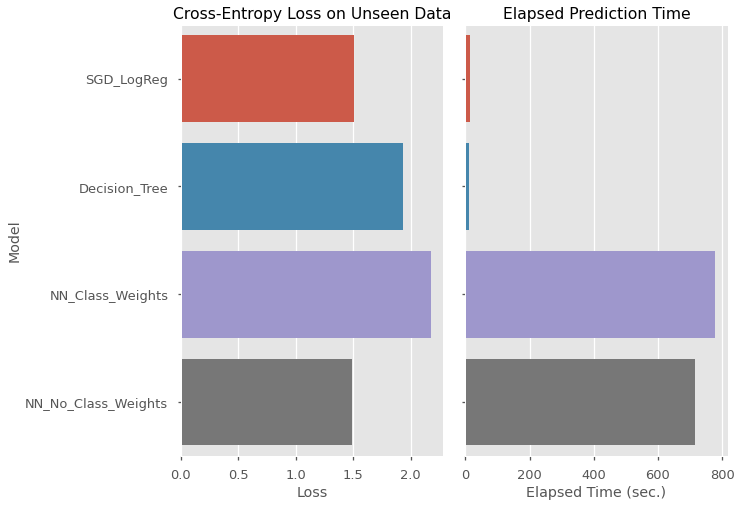

In [19]:
# Visualize comparison.
model_metrics = [
    {'model': 'SGD_LogReg', 
     'loss': sgd_test_loss,
     'time': sgd_elapsed},
    {'model': 'Decision_Tree', 
     'loss': dt_test_loss,
     'time': dt_elapsed},
    {'model': 'NN_Class_Weights', 
     'loss': nn_weights_test_loss,
     'time': nnw_elapsed},
    {'model': 'NN_No_Class_Weights', 
     'loss': nn_no_weights_test_loss,
     'time': nnnw_elapsed}
]

model_df = pd.DataFrame(model_metrics)

with plt.style.context(['ggplot', 'seaborn-talk']):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.barplot(y='model', x='loss', orient='h', data=model_df, ax=ax1)
    ax1.set(title='Cross-Entropy Loss on Unseen Data',
            xlabel='Loss',
            ylabel='Model')
    sns.barplot(y='model', x='time', orient='h', data=model_df, ax=ax2)
    ax2.set(title='Elapsed Prediction Time',
            xlabel='Elapsed Time (sec.)',
            ylabel='')
    fig.tight_layout()

## Neural Network Printouts

```
********************************************************************************
*                       NN - No Class Weights: Test Data                       *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.38      0.01      0.01    262512
           D       0.00      0.00      0.00    109784
           E       0.00      0.00      0.00     28908
          HR       0.00      0.00      0.00     62996
           I       0.00      0.00      0.00     15231
           K       0.40      0.05      0.10    413670
           O       0.48      0.98      0.65   1288789
           S       0.44      0.00      0.00    454308
         SAC       0.45      0.12      0.19     43984
           T       0.00      0.00      0.00     14718

    accuracy                           0.48   2694900
   macro avg       0.22      0.12      0.09   2694900
weighted avg       0.41      0.48      0.33   2694900

            Balanced Accuracy: 0.1164946439065521
Cross-Entropy Loss (Log-Loss): 1.485109473041508
********************************************************************************
*                        NN - Class Weights: Test Data                         *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.16      0.21      0.18    262512
           D       0.05      0.05      0.05    109784
           E       0.02      0.06      0.02     28908
          HR       0.04      0.30      0.08     62996
           I       0.02      0.69      0.04     15231
           K       0.27      0.23      0.25    413670
           O       0.57      0.09      0.16   1288789
           S       0.19      0.01      0.02    454308
         SAC       0.09      0.85      0.17     43984
           T       0.01      0.18      0.02     14718

    accuracy                           0.13   2694900
   macro avg       0.14      0.27      0.10   2694900
weighted avg       0.37      0.13      0.14   2694900

            Balanced Accuracy: 0.2663309705022238
Cross-Entropy Loss (Log-Loss): 2.1744000158027297
```

# Validation

To validate, we will set up simulations for two different teams from a given year (we will choose 2010). 

The Yankees (highest-scoring team of the league) and the Mariners (lowest-scoring team of the league) will be simulated with their opening-day lineup against a 'dummy' Pitcher from the league. 

The results of the simulation will be compared to the actual end-of-year stats for the team.

In [20]:
pf = bsb.PlayerFinder()

# Load in "pre-trained" League.
if 'populated_league.pkl' in os.listdir('./data'):
    print('Loading...')
    with open('./data/populated_league_sm.pkl', 'rb') as infile:
        MLB = pickle.load(infile)
    print('Complete.')
    
MLB

Loading...
Complete.



	**********LEAGUE**********
	Number of Hitters:  10104
	Number of Pitchers: 6416
	Total Players:      16520

In [21]:
nn_sim = bsb.Simulator(
    model_no_weights, 
    MLB, 
    X_preprocessor, 
    y_preprocessor, 
    pf)
sgd_sim = bsb.Simulator(
    log_sgd, 
    MLB, 
    X_preprocessor, 
    y_preprocessor, 
    pf)

In [22]:
# Highest-scoring team of 2010
yanks_2010_opening_day_lineup = [
    ('Jeter', 'Derek'),
    ('Johnson', 'Nick'),
    ('Teixeira', 'Mark'),
    ('Rodriguez', 'Alex'),
    ('Cano', 'Robinson'),
    ('Posada', 'Jorge'),
    ('Granderson', 'Curtis'),
    ('Swisher', 'Nick'),
    ('Gardner', 'Brett')
]
    
yanks_2010_ids = [pf.get_player_id(last_n, first_n) 
                  for last_n, first_n in yanks_2010_opening_day_lineup]
yanks_2010_ids

['jeted001',
 'johnn001',
 'teixm001',
 'rodra001',
 'canor001',
 'posaj001',
 'granc001',
 'swisn001',
 'gardb001']

In [23]:
# Lowest-scoring team of 2010.
mariners_2010_opening_day_lineup = [
    ('Suzuki', 'Ichiro'),
    ('Figgins', 'Chone'),
    ('Kotchman', 'Casey'),
    ('Bradley', 'Milton'),
    ('Griffey', 'Ken'),
    ('Lopez', 'Jose'),
    ('Gutierrez', 'Franklin'),
    ('Johnson', 'Rob'),
    ('Wilson', 'Jack'),
]

mariners_2010_ids = [pf.get_player_id(last_n, first_n, 1985) 
                     for last_n, first_n in mariners_2010_opening_day_lineup]
mariners_2010_ids

['suzui001',
 'figgc001',
 'kotcc001',
 'bradm001',
 'grifk002',
 'lopej003',
 'gutif001',
 'johnr009',
 'wilsj002']

In [24]:
# "Dummy" Pitcher to simulate against.
sheets = pf.get_player_id('Sheets', 'Ben')
sheets

'sheeb001'

Running 81 simulations of 9 innings each.
Instructions for updating:
Please use `model.predict()` instead.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.477
Average Runs Scored (/9-inning-game): 4.296


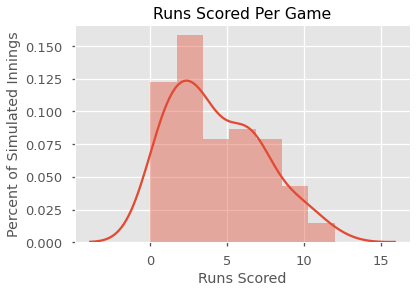

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.562
Average Runs Scored (/9-inning-game): 5.062


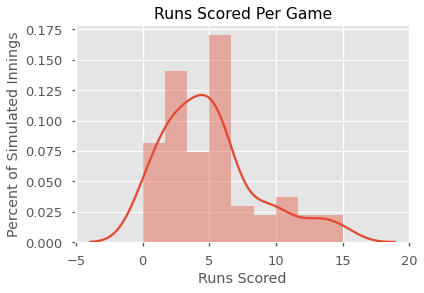

In [25]:
yanks_2010_df_nn, _ = nn_sim.simulate(
    lineup=yanks_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

yanks_2010_df_sgd, _ = sgd_sim.simulate(
    lineup=yanks_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.435
Average Runs Scored (/9-inning-game): 3.914


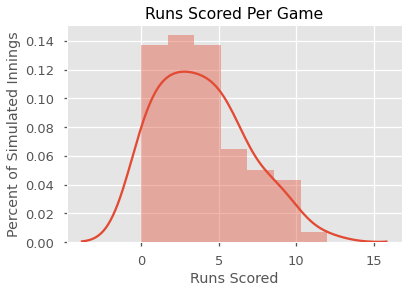

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.521
Average Runs Scored (/9-inning-game): 4.691


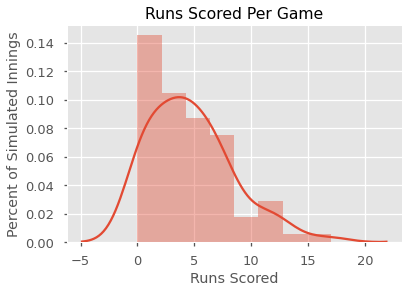

In [26]:
mariners_2010_df_nn, _ = nn_sim.simulate(
    lineup=mariners_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

mariners_2010_df_sgd, _ = sgd_sim.simulate(
    lineup=mariners_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

In [27]:
def compare_actual_to_simulated(df_actual, df_simulated, team_name=''):
    """
    Compares actual runs scored to simulated runs scored 
    for all home games for a given team.
        `df_actual` should have columns ['Opponent', 'Score']
        `df_simulated` should have column [`simulation_total`]
    """
    
    home_games = df_actual[df_actual['Opponent'].map(
        lambda x: 'vs' in x)].copy()
    actual_runs_scored = home_games['Score'].map(
        lambda x: x.split('-')[1]).astype(int)
    print('Actual:    Average Runs per Game:', actual_runs_scored.mean())
    
    simulated_runs_scored = df_simulated['simulation_total']
    print('Simulated: Average Runs per Game:', simulated_runs_scored.mean())
    
    with plt.style.context(['ggplot', 'seaborn-talk']):
        fig, ax = plt.subplots(figsize=(6,4))
        sns.distplot(actual_runs_scored, color='blue', 
                     ax=ax, label='Actual')
        sns.distplot(simulated_runs_scored, color='green', 
                     ax=ax, label='Simulated')
        ax.set(title=f'{team_name} Runs per Home Game'.strip(),
               xlabel='Runs Scored',
               ylabel='Percent of Games')
        ax.legend()
        fig.tight_layout()
        plt.show()

In [28]:
# https://www.baseball-almanac.com/teamstats/schedule.php?y=2010&t=NYA
yankees2010_actual = pd.read_csv('yankees2010_actual.csv', index_col=0)
yankees2010_actual.head()

,Game,Date / Box Score,Opponent,Score,Decision,Record
0,1,04-04-2010,at Boston Red Sox,7-9,L,0-1
1,2,04-06-2010,at Boston Red Sox,6-4,W,1-1
2,3,04-07-2010,at Boston Red Sox,3-1,W,2-1
3,4,04-09-2010,at Tampa Bay Rays,3-9,L,2-2
4,5,04-10-2010,at Tampa Bay Rays,10-0,W,3-2


In [29]:
# https://www.baseball-almanac.com/teamstats/schedule.php?y=2010&t=SEA
mariners2010_actual = pd.read_csv('mariners2010_actual.csv', index_col=0)
mariners2010_actual.head()

,Game,Date / Box Score,Opponent,Score,Decision,Record
0,1,04-05-2010,at Oakland Athletics,5-3,W,1-0
1,2,04-06-2010,at Oakland Athletics,1-2,L,1-1
2,3,04-07-2010,at Oakland Athletics,5-6,L,1-2
3,4,04-08-2010,at Oakland Athletics,2-6,L,1-3
4,5,04-09-2010,at Texas Rangers,2-6,L,1-4


## NN - Actual / Simulated

Actual:    Average Runs per Game: 4.518518518518518
Simulated: Average Runs per Game: 4.296296296296297


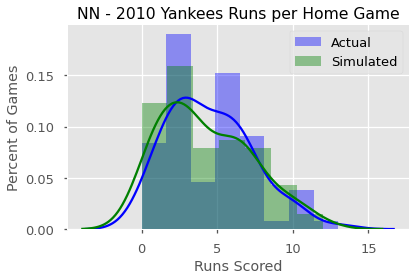

In [30]:
compare_actual_to_simulated(yankees2010_actual, 
                            yanks_2010_df_nn, 
                            'NN - 2010 Yankees')

Actual:    Average Runs per Game: 3.753086419753086
Simulated: Average Runs per Game: 3.9135802469135803


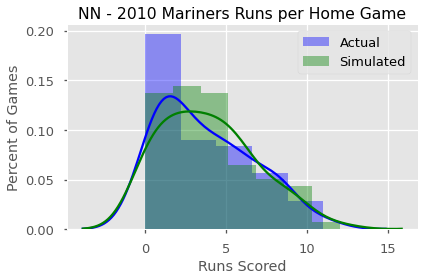

In [31]:
compare_actual_to_simulated(mariners2010_actual, 
                            mariners_2010_df_nn, 
                            'NN - 2010 Mariners')

## SGD - Actual / Simulated

Actual:    Average Runs per Game: 4.518518518518518
Simulated: Average Runs per Game: 5.061728395061729


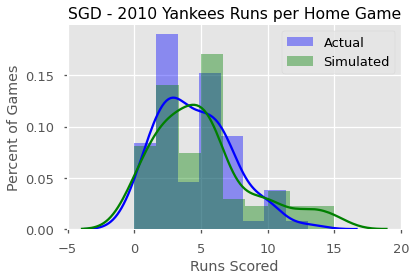

In [32]:
compare_actual_to_simulated(yankees2010_actual, 
                            yanks_2010_df_sgd, 
                            'SGD - 2010 Yankees')

Actual:    Average Runs per Game: 3.753086419753086
Simulated: Average Runs per Game: 4.691358024691358


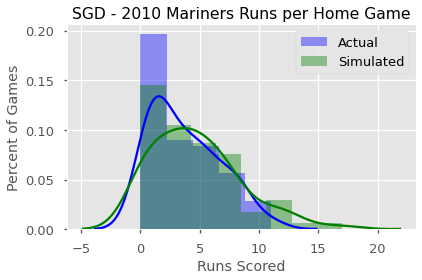

In [33]:
compare_actual_to_simulated(mariners2010_actual, 
                            mariners_2010_df_sgd, 
                            'SGD - 2010 Mariners')

# Batting Order Comparison

In [35]:
# Check what the simulator selects as the optimal lineup.
yankees_optimized = sgd_sim.optimize_lineup(
    yanks_2010_ids,
    sheets,
    simulations_per_order=250
    )

yankees_optimized

********************************************************************************
*                                Lineup locks:                                 *
********************************************************************************
	1. Derek Jeter
	2. Nick Johnson
	3. Mark Teixeira
	4. Alex Rodriguez
	5. Nick Swisher
	6. Brett Gardner
	7. Curtis Granderson
	8. Jorge Posada
	9. Robinson Cano


['jeted001',
 'johnn001',
 'teixm001',
 'rodra001',
 'swisn001',
 'gardb001',
 'granc001',
 'posaj001',
 'canor001']

In [36]:
# Actual lineup
yanks_2010_opening_day_lineup

[('Jeter', 'Derek'),
 ('Johnson', 'Nick'),
 ('Teixeira', 'Mark'),
 ('Rodriguez', 'Alex'),
 ('Cano', 'Robinson'),
 ('Posada', 'Jorge'),
 ('Granderson', 'Curtis'),
 ('Swisher', 'Nick'),
 ('Gardner', 'Brett')]

*The first four spots are interestingly identical! However, spots 5-9 are very different.*

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.578
Average Runs Scored (/9-inning-game): 5.198


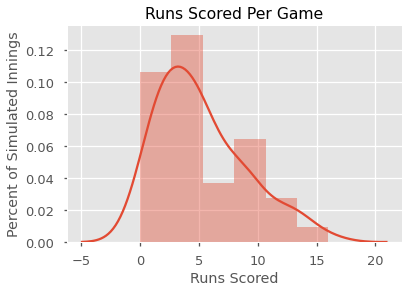

In [37]:
optimized_yanks_df_sgd, _ = sgd_sim.simulate(
    lineup=yankees_optimized,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

Over the course of 81-game simulations, the optimized lineup performed slightly better in terms of expected-runs-scored.